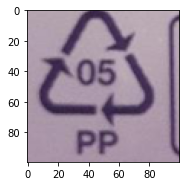

In [1]:
import os
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

resolution = [100,100, 3]

source_dir = 'datasets'



def plot_img(img_matrix):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    
    ax1.imshow(img_matrix.astype('uint8'))

    plt.show()

def get_result(prediction):
    return np.argmax(prediction)

def procces_img(path):
    img_tmp = Image.open(path).resize((resolution[0],resolution[1]))
    return np.array(img_tmp).astype('uint8')

def get_matrix_data(data, resolution, num):

    x_data = []

    for img in data:

        img_matrix = procces_img(f'{source_dir}/{int(num)}/{img}')
        
        x_data.append(img_matrix)
    
    return x_data



def transfrom_data(ratio, source_dir, resolution):

    tmp_train_x = []
    tmp_valid_x = []
    tmp_test_x = []

    train_dataset_x = np.array([])
    valid_dataset_x = np.array([])
    test_dataset_x = np.array([])

    train_dataset_y = np.array([])
    valid_dataset_y = np.array([])
    test_dataset_y = np.array([])

    for nums in  os.listdir(source_dir):

        actual_num  = np.float(nums.split('_')[0])
        
        data = os.listdir(source_dir + '/' + nums)

        # for random take test, train and valid data
        random.shuffle(data)
        
        tmp_train_x.extend(get_matrix_data(data[:int(len(data) * ratio[0])], resolution, actual_num))
        train_dataset_y = np.append(train_dataset_y, np.full((1, int(len(data) * ratio[0])), actual_num))

        tmp_valid_x.extend(get_matrix_data(data[int(len(data) * ratio[0]): int(len(data) * (ratio[0] + ratio[1]))], resolution, actual_num))
        valid_dataset_y = np.append(valid_dataset_y, np.full((1, int(len(data) * (ratio[0] + ratio[1])) - int(len(data) * ratio[0])), actual_num))

        tmp_test_x.extend(get_matrix_data(data[-int(len(data) * ratio[2]):], resolution, actual_num))
        test_dataset_y = np.append(test_dataset_y, np.full((1, int(len(data) * ratio[2])), actual_num))

    train_dataset_x = np.append(train_dataset_x, tmp_train_x)
    train_dataset_x = train_dataset_x.reshape((train_dataset_y.shape[0], resolution[0],resolution[1], 3))

    valid_dataset_x = np.append(valid_dataset_x, tmp_valid_x)
    valid_dataset_x =  valid_dataset_x.reshape((valid_dataset_y.shape[0], resolution[0],resolution[1], 3))

    test_dataset_x = np.append(test_dataset_x ,tmp_test_x)
    test_dataset_x = test_dataset_x.reshape((test_dataset_y.shape[0], resolution[0],resolution[1], 3))

    return {'x': train_dataset_x, 'y': train_dataset_y}, {'x': valid_dataset_x, 'y': valid_dataset_y}, {'x': test_dataset_x, 'y': test_dataset_y}
            
train, valid, test = transfrom_data([0.9, 0.099, 0.01], source_dir, resolution)

plot_img(train['x'][1000])


In [2]:
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import make_circles, make_moons, make_blobs
from matplotlib import pyplot as plt
import numpy as np
import gzip
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Activation, Flatten, MaxPooling2D
from keras import backend as K



base_model = keras.applications.xception.Xception(weights="imagenet", 
                                                  include_top=False, 
                                                  input_shape=(resolution[0], resolution[1], 3))

In [3]:
#freeze the base model 
base_model.trainable = False
#define the type of NN architecture - sequential model specifies a linear stack of layers 
model = keras.models.Sequential()
#add the pre-trained model
model.add(base_model)

In [4]:
#pool layer to prepare data as input into dense layer 
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(256, activation='relu'))
#batch normalization layer re-centers and re-scales the network - helps accelerate training
model.add(keras.layers.BatchNormalization())
#dropout layer - temporarily deactivates 20% of the nodes in the network each epoch to redistribute weights/help network concentrate on "weak" features and prevent overfitting
model.add(keras.layers.Dropout(0.2))
#flatten layer to single array for input into dense layer 
model.add(keras.layers.Flatten())
# prediction layer - 6 neurons = 6 category outputs, and softmax to normalize the output of the network to a probability distribution over the predicted output classes 
model.add(keras.layers.Dense(8, activation='softmax'))

In [5]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [6]:
history = model.fit(train['x'], train['y'], epochs=40, 
                    validation_data = (valid['x'], valid['y']))

Epoch 1/40
325/325 [==============================] - 212s 654ms/step - loss: 1.0662 - accuracy: 0.6481 - val_loss: 1.1162 - val_accuracy: 0.6387
Epoch 2/40
325/325 [==============================] - 147s 453ms/step - loss: 0.7539 - accuracy: 0.7504 - val_loss: 0.8637 - val_accuracy: 0.7183
Epoch 3/40
325/325 [==============================] - 156s 479ms/step - loss: 0.6730 - accuracy: 0.7853 - val_loss: 0.7104 - val_accuracy: 0.7839
Epoch 4/40
325/325 [==============================] - 164s 506ms/step - loss: 0.6285 - accuracy: 0.8066 - val_loss: 0.7465 - val_accuracy: 0.7699
Epoch 5/40
325/325 [==============================] - 151s 465ms/step - loss: 0.5882 - accuracy: 0.8138 - val_loss: 0.8566 - val_accuracy: 0.7087
Epoch 6/40
325/325 [==============================] - 167s 513ms/step - loss: 0.5609 - accuracy: 0.8271 - val_loss: 0.7713 - val_accuracy: 0.7717
Epoch 7/40
325/325 [==============================] - 159s 491ms/step - loss: 0.5363 - accuracy: 0.8338 - val_loss: 0.6027 -

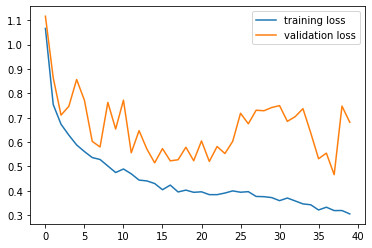

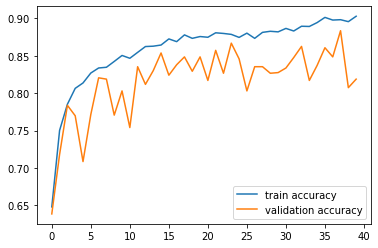

In [7]:
plt.figure()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend(loc='best')

plt.figure()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='best')
plt.show()

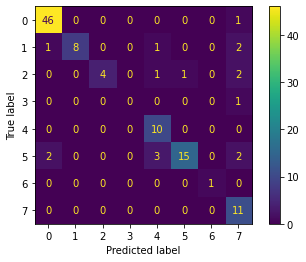

In [8]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

def get_result(prediction):
    return np.argmax(prediction)

predicted = []
counter = 0
for img in test['x']:
    prediction = model.predict(img.reshape((-1, resolution[0], resolution[1], resolution[2])))
    predicted.append(get_result(prediction))

confusion_matrix = metrics.confusion_matrix(test['y'], np.array(predicted))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['0','1','2','3','4','5','6','7'])

cm_display.plot()
plt.show()

In [9]:
train_score = model.evaluate(train['x'], train['y'])
print("\n\ntrain loss: {} | train acc: {}\n".format(train_score[0], train_score[1]))

test_score = model.evaluate(test['x'], test['y'])
print("\n\ntest loss: {} | test acc: {}".format(test_score[0], test_score[1]))

325/325 [==============================] - 133s 409ms/step - loss: 0.4104 - accuracy: 0.8747


train loss: 0.41038334369659424 | train acc: 0.8746992349624634

4/4 [==============================] - 1s 335ms/step - loss: 0.4639 - accuracy: 0.8482


test loss: 0.4638930857181549 | test acc: 0.8482142686843872


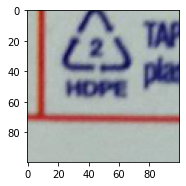

4 --------> 3.0


array([[7.0589349e-02, 8.2792751e-03, 7.5082099e-03, 8.3002364e-05,
        5.4739976e-01, 2.0082667e-03, 1.4600345e-06, 3.6413068e-01]],
      dtype=float32)

In [26]:
img = procces_img('datasets/2/101_20200721142126_hdpe2_002.jpg')
plot_img(img)
prediction = model.predict(img.reshape((-1, resolution[0], resolution[1], resolution[2])))
print(f'{get_result(prediction)} --------> {test["y"][counter]}' )
prediction

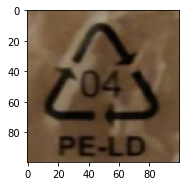

7 --------> 3.0


array([[1.60654604e-01, 1.23736843e-01, 4.61681075e-02, 1.15028786e-04,
        2.62482315e-02, 1.24214865e-01, 6.79491495e-04, 5.18182814e-01]],
      dtype=float32)

In [21]:
img = procces_img('test/Screenshot 2023-01-17 113435.jpg')
plot_img(img)
prediction = model.predict(img.reshape((-1, resolution[0], resolution[1], resolution[2])))
print(f'{get_result(prediction)} --------> {test["y"][counter]}' )
prediction

1.0